In [2]:
import os
import pickle
import glob
import sys
import getpass
import importlib
from tqdm import tqdm
from pathlib import Path

# user path:
usrname = getpass.getuser()
# add paths:
sys.path.append(f'/Users/{usrname}/Desktop/Projects')
sys.path.append(f'/Users/{usrname}/Desktop/Projects/bimanual_wrist')
sys.path.append(f'/Users/{usrname}/Desktop/Projects/Functional_Fusion')
sys.path.append(f'/Users/{usrname}/Desktop/Projects/PcmPy')

import rsatoolbox as rsa
from rsatoolbox.io import spm as spm_io
import surfAnalysisPy as surf
import SUITPy as suit
import nibabel as nb
import nitools as nt
import PcmPy as pcm
import Functional_Fusion.atlas_map as am
import Functional_Fusion.reliability as rel

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.cm import ScalarMappable
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.patches as patches
import seaborn as sns

import scipy.stats as stats
import scipy
import scipy.io as sio
import numpy as np
import pandas as pd

import utils
importlib.reload(utils)

# SET PATHS:
baseDir = os.path.join('/Users', getpass.getuser(), 'Desktop', 'Projects', 'bimanual_wrist', 'data', 'fMRI')
bidsDir = 'BIDS'
anatomicalDir = 'anatomicals'
freesurferDir = 'surfaceFreesurfer'
surfacewbDir = 'surfaceWB' 
behavDir = 'behavioural'
regDir = 'ROI'
atlasDir = '/Volumes/diedrichsen_data$/data/Atlas_templates/fs_LR_32'
analysisDir = os.path.join(os.path.dirname(os.path.dirname(baseDir)), 'analysis')



# Pearson r Intrinsic

============== M1 ==============
Mean Fisher Z: 0.042 +/- 0.020
T-test > 0: t(23) = 2.087, p = 2.4079e-02
============== S1 ==============
Mean Fisher Z: 0.027 +/- 0.017
T-test > 0: t(23) = 1.623, p = 5.9137e-02
============== PMd ==============
Mean Fisher Z: 0.088 +/- 0.020
T-test > 0: t(23) = 4.352, p = 1.1696e-04
============== PMv ==============
Mean Fisher Z: 0.063 +/- 0.024
T-test > 0: t(23) = 2.584, p = 8.2889e-03
============== SMA ==============
Mean Fisher Z: 0.070 +/- 0.011
T-test > 0: t(23) = 6.463, p = 6.7699e-07
============== SPLa ==============
Mean Fisher Z: 0.078 +/- 0.018
T-test > 0: t(23) = 4.330, p = 1.2365e-04
============== SPLp ==============
Mean Fisher Z: 0.083 +/- 0.023
T-test > 0: t(23) = 3.546, p = 8.6104e-04
============== V1 ==============
Mean Fisher Z: 0.091 +/- 0.019
T-test > 0: t(23) = 4.871, p = 3.2151e-05


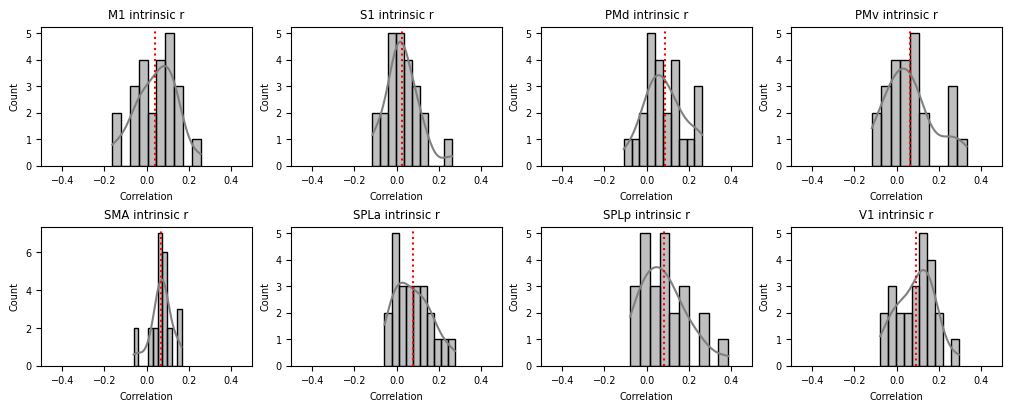

/Users/aghavamp/Desktop/Projects/bimanual_wrist/.conda/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 8.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


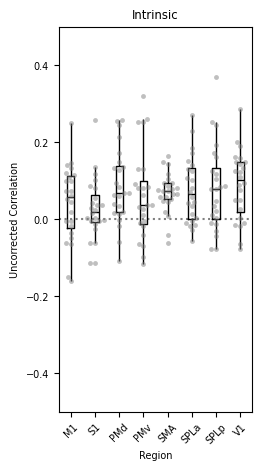

In [ ]:
regions = ['M1','S1','PMd','PMv','SMA','SPLa','SPLp','V1']
region = 'M1'

df = {'region':[], 'r':[], 'fisher_Z':[]}

plt.rcParams.update({'font.size': 7})
fig, axes = plt.subplots(2, len(regions)//2, figsize=(10,4), constrained_layout=True)
for region in regions:
    datafile = os.path.join(analysisDir, f'pcm_dataset_12by12_{region}.npz')

    # load pcm dataset:
    D = np.load(datafile, allow_pickle=True)
    Y = D['Y']
    
    N = len(Y)
    r = []
    fisher_Z = []
    for i in range(N):
        measurements = Y[i].measurements
        cond_vec = Y[i].obs_descriptors['cond_vec']
        num_voxels = measurements.shape[1]
        ncond = 12

        # Create an array to store the averaged patterns for each condition
        averaged_patterns = np.zeros((ncond, num_voxels))

        # Loop through each condition and calculate the average pattern
        for c in range(ncond):
            # Find rows corresponding to the current condition
            condition_indices = cond_vec == c
            # Calculate the mean pattern for the current condition
            averaged_patterns[c, :] = measurements[condition_indices, :].mean(axis=0)

        # get the contra conditions: 
        y_contra_avg = averaged_patterns[0:6, :]
        # remove mean across conditions:
        y_contra_avg = y_contra_avg - y_contra_avg.mean(axis=0)
        # flatten the averaged patterns:
        y_contra_vec = y_contra_avg.flatten()
        
        # get the ipsi conditions:
        y_ipsi_avg = averaged_patterns[6:12, :]
        # remove mean across conditions:
        y_ipsi_avg = y_ipsi_avg - y_ipsi_avg.mean(axis=0)
        # flatten the averaged patterns:
        y_ipsi_vec = y_ipsi_avg.flatten()

        # concatenate the contra and ipsi patterns:
        r.append(np.corrcoef(y_contra_vec, y_ipsi_vec)[0,1])
        fisher_Z.append(np.arctanh(r[-1]))

    r = np.array(r)
    fisher_Z = np.array(fisher_Z)
    df['region'].extend([region] * len(r))
    df['r'].extend(r)
    df['fisher_Z'].extend(fisher_Z)
    print(f'============== {region} ==============')
    print(f'Mean Fisher Z: {np.mean(fisher_Z):.3f} +/- {stats.sem(fisher_Z):.3f}')

    # t-test > 0:
    t_stat, p_val = stats.ttest_1samp(fisher_Z, 0, alternative='greater')
    print(f'T-test > 0: t({N-1}) = {t_stat:.3f}, p = {p_val:.4e}')

    # distribution of r:
    ax = axes.flatten()[regions.index(region)]
    sns.histplot(fisher_Z, kde=True, color='gray', ax=ax, bins=10)
    ax.axvline(np.mean(fisher_Z), color='red', linestyle=':')
    ax.set_xlabel('Correlation')
    ax.set_ylabel('Count')
    ax.set_title(f'{region} intrinsic r')
    ax.set_xlim(-0.5,0.5)
plt.show()

df = pd.DataFrame(df)
# boxplot:
plt.figure(figsize=(2.5,5))
plt.axhline(0, color='gray', linestyle=':')
sns.swarmplot(x='region', y='r', data=df, color='gray', size=3.5, alpha=0.5)
sns.boxplot(x='region', y='r', data=df, width=0.3, color='k', fill=False, showcaps=False, linewidth=1, fliersize=0)
plt.xlabel('Region')
plt.ylabel('Uncorrected Correlation')
plt.title('Intrinsic')
plt.ylim(-0.5,0.5)
# rotate x-tick labels:
plt.xticks(rotation=45)
plt.show()





# Pearson r Extrinsic

============== M1 ==============
Mean Fisher Z: 0.014 +/- 0.019
T-test > 0: t(23) = 0.745, p = 2.3199e-01
============== S1 ==============
Mean Fisher Z: 0.014 +/- 0.018
T-test > 0: t(23) = 0.768, p = 2.2501e-01
============== PMd ==============
Mean Fisher Z: -0.001 +/- 0.016
T-test > 0: t(23) = -0.039, p = 5.1533e-01
============== PMv ==============
Mean Fisher Z: 0.016 +/- 0.017
T-test > 0: t(23) = 0.925, p = 1.8217e-01
============== SMA ==============
Mean Fisher Z: -0.006 +/- 0.012
T-test > 0: t(23) = -0.550, p = 7.0613e-01
============== SPLa ==============
Mean Fisher Z: 0.033 +/- 0.018
T-test > 0: t(23) = 1.882, p = 3.6269e-02
============== SPLp ==============
Mean Fisher Z: 0.001 +/- 0.022
T-test > 0: t(23) = 0.057, p = 4.7755e-01
============== V1 ==============
Mean Fisher Z: 0.075 +/- 0.022
T-test > 0: t(23) = 3.330, p = 1.4567e-03


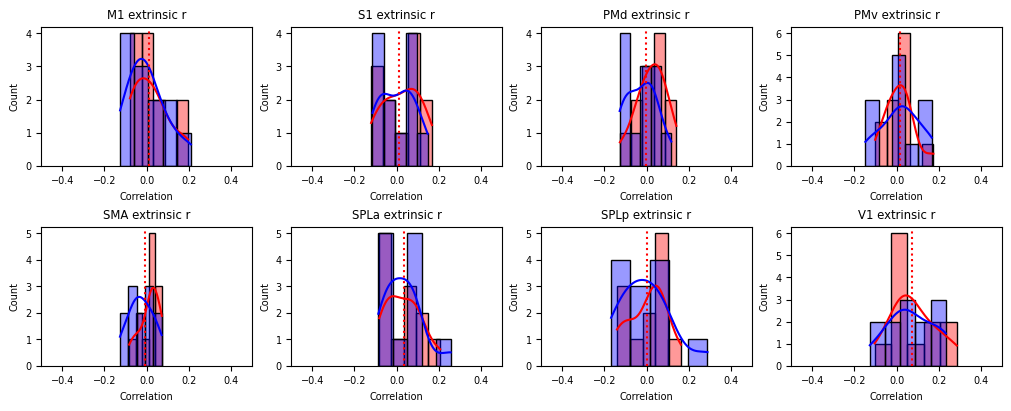

/Users/aghavamp/Desktop/Projects/bimanual_wrist/.conda/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 8.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


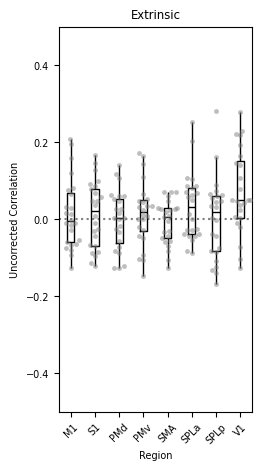

In [5]:
regions = ['M1','S1','PMd','PMv','SMA','SPLa','SPLp','V1']
df = {'region':[], 'r':[], 'fisher_Z':[]}

fig, axes = plt.subplots(2, len(regions)//2, figsize=(10,4), constrained_layout=True)
for region in regions:
    datafile = os.path.join(analysisDir, f'pcm_dataset_extrinsic_12by12_{region}.npz')

    # load pcm dataset:
    D = np.load(datafile, allow_pickle=True)
    Y = D['Y']
    
    N = len(Y)
    r = []
    fisher_Z = []
    for i in range(N):
        measurements = Y[i].measurements
        cond_vec = Y[i].obs_descriptors['cond_vec']
        num_voxels = measurements.shape[1]
        ncond = 12

        # Create an array to store the averaged patterns for each condition
        averaged_patterns = np.zeros((ncond, num_voxels))

        # Loop through each condition and calculate the average pattern
        for c in range(ncond):
            # Find rows corresponding to the current condition
            condition_indices = cond_vec == c
            # Calculate the mean pattern for the current condition
            averaged_patterns[c, :] = measurements[condition_indices, :].mean(axis=0)

        # get the contra conditions: 
        y_contra_avg = averaged_patterns[0:6, :]
        # remove mean across conditions:
        y_contra_avg = y_contra_avg - y_contra_avg.mean(axis=0)
        # flatten the averaged patterns:
        y_contra_vec = y_contra_avg.flatten()
        
        # get the ipsi conditions:
        y_ipsi_avg = averaged_patterns[6:12, :]
        # remove mean across conditions:
        y_ipsi_avg = y_ipsi_avg - y_ipsi_avg.mean(axis=0)
        # flatten the averaged patterns:
        y_ipsi_vec = y_ipsi_avg.flatten()

        # concatenate the contra and ipsi patterns:
        r.append(np.corrcoef(y_contra_vec, y_ipsi_vec)[0,1])
        fisher_Z.append(np.arctanh(r[-1]))


    r = np.array(r)
    fisher_Z = np.array(fisher_Z)
    df['region'].extend([region] * len(r))
    df['r'].extend(r)
    df['fisher_Z'].extend(fisher_Z)
    print(f'============== {region} ==============')
    print(f'Mean Fisher Z: {np.mean(fisher_Z):.3f} +/- {stats.sem(fisher_Z):.3f}')

    # t-test > 0:
    t_stat, p_val = stats.ttest_1samp(fisher_Z, 0, alternative='greater')
    print(f'T-test > 0: t({N-1}) = {t_stat:.3f}, p = {p_val:.4e}')
    
    # distribution of r:
    ax = axes.flatten()[regions.index(region)]
    sns.histplot(fisher_Z[0:12], kde=True, color='red', alpha=0.4, ax=ax)
    sns.histplot(fisher_Z[12:24], kde=True, color='blue', alpha=0.4, ax=ax)
    ax.axvline(np.mean(fisher_Z), color='red', linestyle=':')
    ax.set_xlabel('Correlation')
    ax.set_ylabel('Count')
    ax.set_title(f'{region} extrinsic r')
    ax.set_xlim(-0.5,0.5)
plt.show()

# boxplot:
plt.figure(figsize=(2.5,5))
plt.axhline(0, color='gray', linestyle=':')
sns.swarmplot(x='region', y='r', data=df, color='gray', size=3.5, alpha=0.5)
sns.boxplot(x='region', y='r', data=df, width=0.3, color='k', fill=False, showcaps=False, linewidth=1, fliersize=0)
plt.xlabel('Region')
plt.ylabel('Uncorrected Correlation')
plt.title('Extrinsic')
plt.ylim(-0.5,0.5)
# rotate x-tick labels:
plt.xticks(rotation=45)
plt.show()



# PCM Correlation Intrinsic

In [6]:
regions = ['M1','S1','PMd','PMv','SMA','SPLa','SPLp','V1']

for region in regions:
    file_path = os.path.join(analysisDir, f'pcm_Ghat_best_within_model_{region}.npz')
    data = np.load(file_path)
    G_mdl = data['G_hat']
    G_mdl = G_mdl / np.trace(G_mdl)
    C = G_mdl
    within_cov = C.reshape(1,6,6)

    # setup the dataset for this analysis:
    datafile = os.path.join(analysisDir, f'pcm_dataset_12by12_{region}.npz')
    
    # load pcm dataset:
    D = np.load(datafile, allow_pickle=True)
    Y = D['Y'].tolist()

    nsteps = 200 # how many correlation models
    M = []

    # Generate the models
    for r in np.linspace(-1, 1, nsteps):
        M.append(pcm.CorrelationModel(f"{r:0.2f}", num_items=6, corr=r, cond_effect=True, within_cov=None))

    # Now make the flexible model
    Mflex = pcm.CorrelationModel("flex", num_items=6, corr=None, cond_effect=True, within_cov=None)
    M.append(Mflex)

    T, theta = pcm.fit_model_individ(Y, M, fixed_effect='block', fit_scale=False, verbose=False)

    L = T.likelihood.to_numpy()

    # express log-likelihoods relative to mean
    L = L - L.mean(axis=1).reshape(-1,1)
    maxL = L[:,-1] # Last model is the flexible
    L = L[:,0:-1] # Remove it

    # Get the correlation for each of the models
    r = np.empty((nsteps,))
    for i in range(nsteps):
        r[i]= M[i].corr

    # Get the maximum likelihood estimate of each parameter
    maxr = M[-1].get_correlation(theta[-1])
    
    # FSNR for flex model:
    theta1 = np.exp(theta[-1][2,:])
    theta2 = np.exp(theta[-1][3,:])
    theta_noise = np.exp(theta[-1][-1,:])
    fsnr = np.sqrt(theta1*theta2*10) / theta_noise

    # save results:
    outname = os.path.join(analysisDir, f'pcm_corr_unimanual_intrinsic_{region}.npz')
    np.savez(outname, r=r, L=L, maxr=maxr, maxL=maxL, fsnr=fsnr)





plot

============== M1 ==============
maxr = 0.300 +/- 0.182
Testing correlation of 0.01 against 1.00
Paired-samples t-test: t(23)=-1.625; p(23)=0.117719
One-sample t-test maxr vs 0: t(23)=1.646; p=0.113394
============== S1 ==============
maxr = 0.316 +/- 0.180
Testing correlation of 0.01 against 1.00
Paired-samples t-test: t(23)=-1.603; p(23)=0.122655
One-sample t-test maxr vs 0: t(23)=1.749; p=0.093569
============== PMd ==============
maxr = 0.587 +/- 0.150
Testing correlation of 0.01 against 1.00
Paired-samples t-test: t(23)=-3.021; p(23)=0.006086
One-sample t-test maxr vs 0: t(23)=3.911; p=0.000702
============== PMv ==============
maxr = 0.346 +/- 0.173
Testing correlation of 0.01 against 1.00
Paired-samples t-test: t(23)=-2.103; p(23)=0.046581
One-sample t-test maxr vs 0: t(23)=2.000; p=0.057445
============== SMA ==============
maxr = 0.784 +/- 0.117
Testing correlation of 0.01 against 1.00
Paired-samples t-test: t(23)=-3.032; p(23)=0.005934
One-sample t-test maxr vs 0: t(23)=6.678

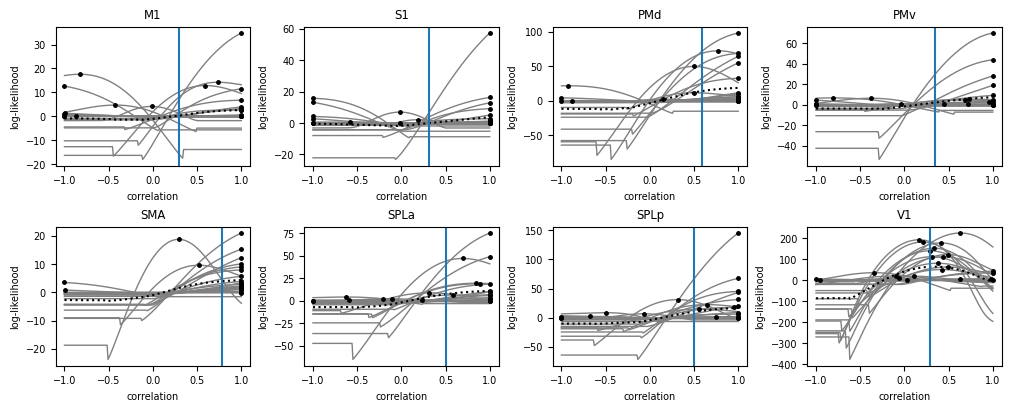

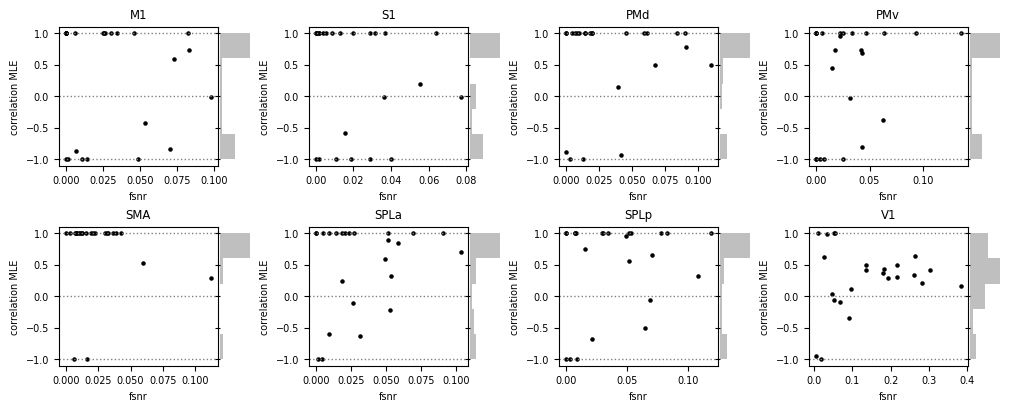

In [7]:
regions = ['M1','S1','PMd','PMv','SMA','SPLa','SPLp','V1']
from mpl_toolkits.axes_grid1 import make_axes_locatable  # add this import

df = {'region':[], 'maxr':[]}

plt.rcParams.update({'font.size': 7})
fig, axes = plt.subplots(2, len(regions)//2, figsize=(10,4), constrained_layout=True)
for region in regions:
    # load results:
    datafile = os.path.join(analysisDir, f'pcm_corr_unimanual_intrinsic_{region}.npz')
    D = np.load(datafile, allow_pickle=True)
    r = D['r']
    L = D['L']
    maxr = D['maxr']
    df['region'].extend([region] * len(maxr))
    df['maxr'].extend(maxr)
    maxL = D['maxL']
    print(f'============== {region} ==============')
    print(f'maxr = {np.mean(maxr):.3f} +/- {stats.sem(maxr):.3f}')

    # t-test of r=1 vs 0 
    i1 = 100
    i2 = -1
    print(f"Testing correlation of {r[i1]:0.2f} against {r[i2]:0.2f}")
    t, p = stats.ttest_rel(L[:,i1], L[:,i2], alternative='two-sided')
    print(f'Paired-samples t-test: t({len(L)-1})={t:1.3f}; p({len(L)-1})={p:1.6f}')

    # t-test maxr vs 0:
    t, p = stats.ttest_1samp(maxr, 0, alternative='two-sided')
    print(f'One-sample t-test maxr vs 0: t({len(maxr)-1})={t:1.3f}; p={p:1.6f}')

    # Plot
    ax = axes.flatten()[regions.index(region)]
    ax.plot(r, L.T, color='gray', marker=None, linewidth=1)
    ax.plot(maxr, maxL, 'k.', markersize=5)
    ax.plot(r, L.mean(axis=0), 'k:')
    ax.axvline(maxr.mean())
    ax.set_xlabel('correlation')
    ax.set_ylabel('log-likelihood')
    ax.set_title(f'{region}')
    # ax.set_ylim((-100,60))
plt.show()

fig, axes = plt.subplots(2, len(regions)//2, figsize=(10,4), constrained_layout=True)
for region in regions:
    # load results:
    datafile = os.path.join(analysisDir, f'pcm_corr_unimanual_intrinsic_{region}.npz')
    D = np.load(datafile, allow_pickle=True)
    r = D['r']
    L = D['L']
    maxr = D['maxr']
    fsnr = D['fsnr']
    # Plot
    ax = axes.flatten()[regions.index(region)]
    ax.axhline(0, color='gray', linestyle=':', linewidth=1)
    ax.axhline(1, color='gray', linestyle=':', linewidth=1)
    ax.axhline(-1, color='gray', linestyle=':', linewidth=1)
    ax.scatter(fsnr, maxr, color='k', s=5)

    # --- vertical marginal histogram of correlation MLE (maxr) ---
    divider = make_axes_locatable(ax)
    ax_marg = divider.append_axes("right", size="20%", pad=0.02, sharey=ax)
    ax_marg.hist(maxr, bins=5, orientation='horizontal', color='gray', alpha=0.5, edgecolor='none')
    # clean up marginal axis
    ax_marg.set_xticks([])
    ax_marg.set_xlabel('')
    plt.setp(ax_marg.get_yticklabels(), visible=False)
    for spine in ax_marg.spines.values():
        spine.set_visible(False)
    # -------------------------------------------------------------

    ax.set_xlabel('fsnr')
    ax.set_ylabel('correlation MLE')
    ax.set_title(f'{region}')
plt.show()



# PCM Correlation Extrinsic sorted

In [89]:
regions = ['M1','S1','PMd','PMv','SMA','SPLa','SPLp','V1']

for region in regions:
    file_path = os.path.join(analysisDir, f'pcm_Ghat_best_within_model_{region}.npz')
    data = np.load(file_path)
    G_mdl = data['G_hat']
    G_mdl = G_mdl / np.trace(G_mdl)
    C = G_mdl
    within_cov = C.reshape(1,6,6)

    # setup the dataset for this analysis:
    datafile = os.path.join(analysisDir, f'pcm_dataset_extrinsic_12by12_{region}.npz')

    # load pcm dataset:
    D = np.load(datafile, allow_pickle=True)
    Y = D['Y'].tolist()

    nsteps = 200 # how many correlation models
    M = []

    # Generate the models
    for r in np.linspace(-1, 1, nsteps):
        M.append(pcm.CorrelationModel(f"{r:0.2f}", num_items=6, corr=r, cond_effect=True, within_cov=None))

    # Now make the flexible model
    Mflex = pcm.CorrelationModel("flex", num_items=6, corr=None, cond_effect=True, within_cov=None)
    M.append(Mflex)

    T, theta = pcm.fit_model_individ(Y, M, fixed_effect='block', fit_scale=False, verbose=False)

    L = T.likelihood.to_numpy()

    # express log-likelihoods relative to mean
    L = L - L.mean(axis=1).reshape(-1,1)
    maxL = L[:,-1] # Last model is the flexible
    L = L[:,0:-1] # Remove it

    # Get the correlation for each of the models
    r = np.empty((nsteps,))
    for i in range(nsteps):
        r[i]= M[i].corr

    # Get the maximum likelihood estimate of each parameter
    maxr = M[-1].get_correlation(theta[-1])

    # FSNR for flex model:
    theta1 = np.exp(theta[-1][2,:])
    theta2 = np.exp(theta[-1][3,:])
    theta_noise = np.exp(theta[-1][-1,:])
    fsnr = np.sqrt(theta1*theta2*10) / theta_noise

    # save results:
    outname = os.path.join(analysisDir, f'pcm_corr_unimanual_extrinsic_{region}.npz')
    np.savez(outname, r=r, L=L, maxr=maxr, maxL=maxL, fsnr=fsnr)



plot

============== M1 ==============
maxr = -0.034 +/- 0.180
Testing correlation of 0.01 against 1.00
Paired-samples t-test: t(23)=-1.547; p(23)=0.135631
One-sample t-test maxr vs 0: t(23)=-0.188; p=0.852642
============== S1 ==============
maxr = 0.097 +/- 0.194
Testing correlation of 0.01 against 1.00
Paired-samples t-test: t(23)=-2.171; p(23)=0.040504
One-sample t-test maxr vs 0: t(23)=0.498; p=0.622883
============== PMd ==============
maxr = 0.103 +/- 0.180
Testing correlation of 0.01 against 1.00
Paired-samples t-test: t(23)=0.364; p(23)=0.719289
One-sample t-test maxr vs 0: t(23)=0.574; p=0.571642
============== PMv ==============
maxr = 0.197 +/- 0.181
Testing correlation of 0.01 against 1.00
Paired-samples t-test: t(23)=-0.218; p(23)=0.829008
One-sample t-test maxr vs 0: t(23)=1.086; p=0.288787
============== SMA ==============
maxr = 0.076 +/- 0.186
Testing correlation of 0.01 against 1.00
Paired-samples t-test: t(23)=0.607; p(23)=0.549618
One-sample t-test maxr vs 0: t(23)=0.409

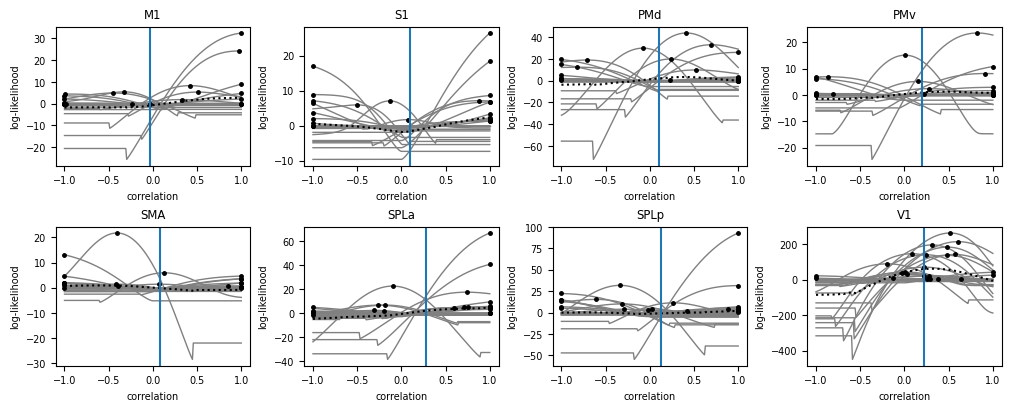

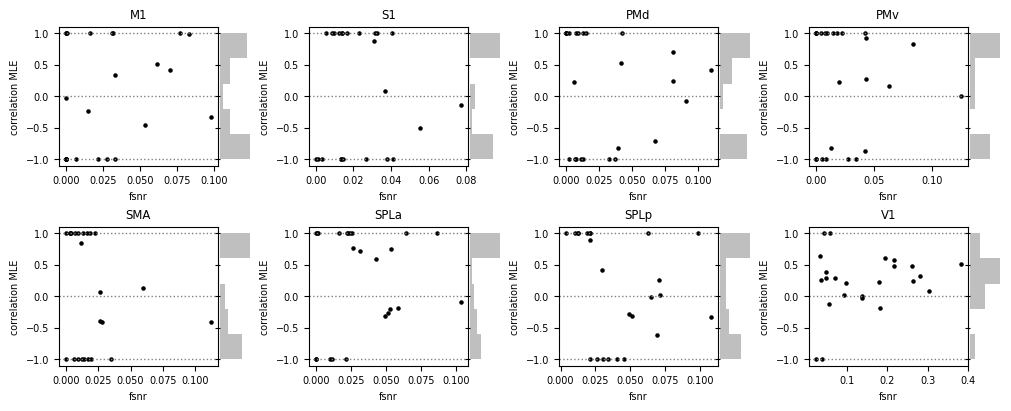

In [91]:
regions = ['M1','S1','PMd','PMv','SMA','SPLa','SPLp','V1']

plt.rcParams.update({'font.size': 7})
fig, axes = plt.subplots(2, len(regions)//2, figsize=(10,4), constrained_layout=True)
for region in regions:
    # load results:
    datafile = os.path.join(analysisDir, f'pcm_corr_unimanual_extrinsic_{region}.npz')
    D = np.load(datafile, allow_pickle=True)
    r = D['r']
    L = D['L']
    maxr = D['maxr']
    maxL = D['maxL']
    print(f'============== {region} ==============')
    print(f'maxr = {np.mean(maxr):.3f} +/- {stats.sem(maxr):.3f}')

    # t-test of r=1 vs 0 
    i1 = 100
    i2 = -1
    print(f"Testing correlation of {r[i1]:0.2f} against {r[i2]:0.2f}")
    t, p = stats.ttest_rel(L[:,i1], L[:,i2], alternative='two-sided')
    print(f'Paired-samples t-test: t({len(L)-1})={t:1.3f}; p({len(L)-1})={p:1.6f}')

    # t-test maxr vs 0:
    t, p = stats.ttest_1samp(maxr, 0, alternative='two-sided')
    print(f'One-sample t-test maxr vs 0: t({len(maxr)-1})={t:1.3f}; p={p:1.6f}')

    # Plot
    ax = axes.flatten()[regions.index(region)]
    ax.plot(r, L.T, color='gray', marker=None, linewidth=1)
    ax.plot(maxr, maxL, 'k.', markersize=5)
    ax.plot(r, L.mean(axis=0), 'k:')
    ax.axvline(maxr.mean())
    ax.set_xlabel('correlation')
    ax.set_ylabel('log-likelihood')
    ax.set_title(f'{region}')
plt.show()

fig, axes = plt.subplots(2, len(regions)//2, figsize=(10,4), constrained_layout=True)
for region in regions:
    # load results:
    datafile = os.path.join(analysisDir, f'pcm_corr_unimanual_extrinsic_{region}.npz')
    D = np.load(datafile, allow_pickle=True)
    r = D['r']
    L = D['L']
    maxr = D['maxr']
    fsnr = D['fsnr']
    # Plot
    ax = axes.flatten()[regions.index(region)]
    ax.axhline(0, color='gray', linestyle=':', linewidth=1)
    ax.axhline(1, color='gray', linestyle=':', linewidth=1)
    ax.axhline(-1, color='gray', linestyle=':', linewidth=1)
    ax.scatter(fsnr, maxr, color='k', s=5)

    # --- vertical marginal histogram of correlation MLE (maxr) ---
    divider = make_axes_locatable(ax)
    ax_marg = divider.append_axes("right", size="20%", pad=0.02, sharey=ax)
    ax_marg.hist(maxr, bins=5, orientation='horizontal', color='gray', alpha=0.5, edgecolor='none')
    # clean up marginal axis
    ax_marg.set_xticks([])
    ax_marg.set_xlabel('')
    plt.setp(ax_marg.get_yticklabels(), visible=False)
    for spine in ax_marg.spines.values():
        spine.set_visible(False)
    # -------------------------------------------------------------

    ax.set_xlabel('fsnr')
    ax.set_ylabel('correlation MLE')
    ax.set_title(f'{region}')
plt.show()






# Pearson r Intrinsic Bootstrapping

============== M1 ==============
Mean Pearson r: 0.042 +/- 0.020
T-test > 0: t(23) = 2.092, p = 2.3813e-02
============== S1 ==============
Mean Pearson r: 0.027 +/- 0.017
T-test > 0: t(23) = 1.626, p = 5.8786e-02
============== PMd ==============
Mean Pearson r: 0.087 +/- 0.020
T-test > 0: t(23) = 4.375, p = 1.1050e-04
============== PMv ==============
Mean Pearson r: 0.062 +/- 0.024
T-test > 0: t(23) = 2.593, p = 8.1236e-03
============== SMA ==============
Mean Pearson r: 0.069 +/- 0.011
T-test > 0: t(23) = 6.370, p = 8.4134e-07
============== SPLa ==============
Mean Pearson r: 0.077 +/- 0.018
T-test > 0: t(23) = 4.368, p = 1.1253e-04
============== SPLp ==============
Mean Pearson r: 0.081 +/- 0.023
T-test > 0: t(23) = 3.585, p = 7.8339e-04
============== V1 ==============
Mean Pearson r: 0.090 +/- 0.018
T-test > 0: t(23) = 4.925, p = 2.8111e-05


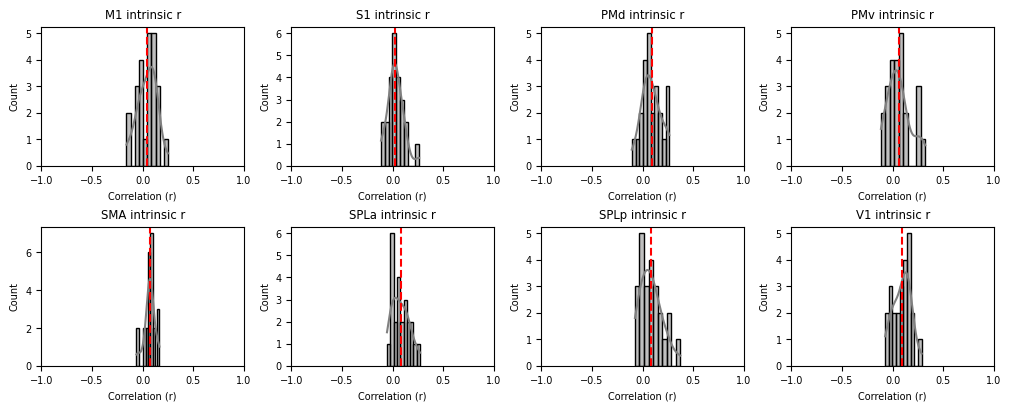

In [19]:
regions = ['M1','S1','PMd','PMv','SMA','SPLa','SPLp','V1']
region = 'M1'

def bootstrap_roi_correlation(condA, condB, m=200, B=2000, rng=None):
    """
    condA, condB: 1D arrays of length V (voxels) with condition pattern values (e.g., beta estimates)
    m: subset size of voxels to sample without replacement each bootstrap
    B: number of bootstrap replicates
    Returns:
      z_bar: mean Fisher-z across replicates (per-hemisphere estimator for group level)
      r_ci: 95% CI on r from bootstrap percentiles (optional descriptive)
      r_dist: array of bootstrap r values (for diagnostics)
    """
    assert condA.shape == condB.shape
    V = condA.size
    if rng is None:
        rng = np.random.default_rng(1234)
    r_vals = np.empty(B, dtype=float)
    vox = np.arange(V)
    for b in range(B):
        idx = rng.choice(vox, size=m, replace=False)
        a = condA[idx]
        c = condB[idx]
        # demean to mitigate mean shifts across conditions
        a = a - a.mean()
        c = c - c.mean()
        num = np.dot(a, c)
        den = np.linalg.norm(a) * np.linalg.norm(c)
        r = num / den if den > 0 else 0.0
        r_vals[b] = np.clip(r, -0.999999, 0.999999)
    z_vals = np.arctanh(r_vals)
    z_bar = np.nanmean(z_vals)
    # Descriptive 95% CI on r via percentile in z-space then back-transform
    z_lo, z_hi = np.nanpercentile(z_vals, [2.5, 97.5])
    r_ci = (np.tanh(z_lo), np.tanh(z_hi))
    return z_bar, r_ci, r_vals

plt.rcParams.update({'font.size': 7})
fig, axes = plt.subplots(2, len(regions)//2, figsize=(10,4), constrained_layout=True)
for region in regions:
    datafile = os.path.join(analysisDir, f'pcm_dataset_12by12_{region}.npz')

    # load pcm dataset:
    D = np.load(datafile, allow_pickle=True)
    Y = D['Y']
    
    N = len(Y)
    r = []
    for i in range(N):
        measurements = Y[i].measurements
        cond_vec = Y[i].obs_descriptors['cond_vec']
        num_voxels = measurements.shape[1]
        ncond = 12

        # Create an array to store the averaged patterns for each condition
        averaged_patterns = np.zeros((ncond, num_voxels))
        
        # Loop through each condition and calculate the average pattern
        for c in range(ncond):
            # Find rows corresponding to the current condition
            condition_indices = cond_vec == c
            # Calculate the mean pattern for the current condition
            averaged_patterns[c, :] = measurements[condition_indices, :].mean(axis=0)

        # get the contra conditions: 
        y_contra_avg = averaged_patterns[0:6, :]
        # remove mean across conditions:
        y_contra_avg = y_contra_avg - y_contra_avg.mean(axis=0)
        # flatten the averaged patterns:
        y_contra_vec = y_contra_avg.flatten()
        
        # get the ipsi conditions:
        y_ipsi_avg = averaged_patterns[6:12, :]
        # remove mean across conditions:
        y_ipsi_avg = y_ipsi_avg - y_ipsi_avg.mean(axis=0)
        # flatten the averaged patterns:
        y_ipsi_vec = y_ipsi_avg.flatten()

        z_bar, r_ci, r_dist = bootstrap_roi_correlation(y_contra_vec, y_ipsi_vec, m=200, B=2000, rng=None)
        r.append(np.tanh(z_bar))


    r = np.array(r)
    print(f'============== {region} ==============')
    print(f'Mean Pearson r: {np.mean(r):.3f} +/- {stats.sem(r):.3f}')

    # t-test > 0:
    t_stat, p_val = stats.ttest_1samp(r, 0, alternative='greater')
    print(f'T-test > 0: t({N-1}) = {t_stat:.3f}, p = {p_val:.4e}')

    # distribution of r:
    ax = axes.flatten()[regions.index(region)]
    sns.histplot(r, kde=True, color='gray', ax=ax, bins=10)
    ax.axvline(np.mean(r), color='red', linestyle='--', label='Mean r')
    ax.set_xlabel('Correlation (r)')
    ax.set_ylabel('Count')
    ax.set_title(f'{region} intrinsic r')
    ax.set_xlim(-1,1)
plt.show()




# Pearson r Extrinsic bootstrap 

============== M1 ==============
Mean Pearson r: 0.014 +/- 0.019
T-test > 0: t(23) = 0.743, p = 2.3252e-01
============== S1 ==============
Mean Pearson r: 0.014 +/- 0.018
T-test > 0: t(23) = 0.768, p = 2.2522e-01
============== PMd ==============
Mean Pearson r: -0.000 +/- 0.016
T-test > 0: t(23) = -0.018, p = 5.0697e-01
============== PMv ==============
Mean Pearson r: 0.016 +/- 0.017
T-test > 0: t(23) = 0.958, p = 1.7413e-01
============== SMA ==============
Mean Pearson r: -0.006 +/- 0.012
T-test > 0: t(23) = -0.546, p = 7.0483e-01
============== SPLa ==============
Mean Pearson r: 0.033 +/- 0.018
T-test > 0: t(23) = 1.867, p = 3.7381e-02
============== SPLp ==============
Mean Pearson r: 0.001 +/- 0.022
T-test > 0: t(23) = 0.065, p = 4.7441e-01
============== V1 ==============
Mean Pearson r: 0.074 +/- 0.022
T-test > 0: t(23) = 3.330, p = 1.4577e-03


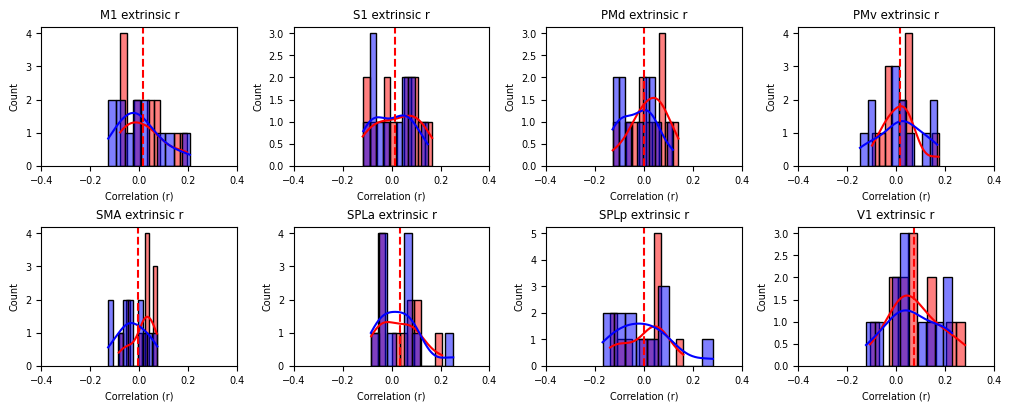

In [22]:
regions = ['M1','S1','PMd','PMv','SMA','SPLa','SPLp','V1']
region = 'M1'

def bootstrap_roi_correlation(condA, condB, m=200, B=2000, rng=None):
    """
    condA, condB: 1D arrays of length V (voxels) with condition pattern values (e.g., beta estimates)
    m: subset size of voxels to sample without replacement each bootstrap
    B: number of bootstrap replicates
    Returns:
      z_bar: mean Fisher-z across replicates (per-hemisphere estimator for group level)
      r_ci: 95% CI on r from bootstrap percentiles (optional descriptive)
      r_dist: array of bootstrap r values (for diagnostics)
    """
    assert condA.shape == condB.shape
    V = condA.size
    if rng is None:
        rng = np.random.default_rng(1234)
    r_vals = np.empty(B, dtype=float)
    vox = np.arange(V)
    for b in range(B):
        idx = rng.choice(vox, size=m, replace=False)
        a = condA[idx]
        c = condB[idx]
        # demean to mitigate mean shifts across conditions
        a = a - a.mean()
        c = c - c.mean()
        num = np.dot(a, c)
        den = np.linalg.norm(a) * np.linalg.norm(c)
        r = num / den if den > 0 else 0.0
        r_vals[b] = np.clip(r, -0.999999, 0.999999)
    z_vals = np.arctanh(r_vals)
    z_bar = np.nanmean(z_vals)
    # Descriptive 95% CI on r via percentile in z-space then back-transform
    z_lo, z_hi = np.nanpercentile(z_vals, [2.5, 97.5])
    r_ci = (np.tanh(z_lo), np.tanh(z_hi))
    return z_bar, r_ci, r_vals

plt.rcParams.update({'font.size': 7})
fig, axes = plt.subplots(2, len(regions)//2, figsize=(10,4), constrained_layout=True)
for region in regions:
    datafile = os.path.join(analysisDir, f'pcm_dataset_extrinsic_12by12_{region}.npz')

    # load pcm dataset:
    D = np.load(datafile, allow_pickle=True)
    Y = D['Y']
    
    N = len(Y)
    r = []
    for i in range(N):
        measurements = Y[i].measurements
        cond_vec = Y[i].obs_descriptors['cond_vec']
        num_voxels = measurements.shape[1]
        ncond = 12
        
        # Create an array to store the averaged patterns for each condition
        averaged_patterns = np.zeros((ncond, num_voxels))
        
        # Loop through each condition and calculate the average pattern
        for c in range(ncond):
            # Find rows corresponding to the current condition
            condition_indices = cond_vec == c
            # Calculate the mean pattern for the current condition
            averaged_patterns[c, :] = measurements[condition_indices, :].mean(axis=0)

        # get the contra conditions: 
        y_contra_avg = averaged_patterns[0:6, :]
        # remove mean across conditions:
        y_contra_avg = y_contra_avg - y_contra_avg.mean(axis=0)
        # flatten the averaged patterns:
        y_contra_vec = y_contra_avg.flatten()
        
        # get the ipsi conditions:
        y_ipsi_avg = averaged_patterns[6:12, :]
        # remove mean across conditions:
        y_ipsi_avg = y_ipsi_avg - y_ipsi_avg.mean(axis=0)
        # flatten the averaged patterns:
        y_ipsi_vec = y_ipsi_avg.flatten()

        z_bar, r_ci, r_dist = bootstrap_roi_correlation(y_contra_vec, y_ipsi_vec, m=200, B=2000, rng=None)
        r.append(np.tanh(z_bar))


    r = np.array(r)
    print(f'============== {region} ==============')
    print(f'Mean Pearson r: {np.mean(r):.3f} +/- {stats.sem(r):.3f}')

    # t-test > 0:
    t_stat, p_val = stats.ttest_1samp(r, 0, alternative='greater')
    print(f'T-test > 0: t({N-1}) = {t_stat:.3f}, p = {p_val:.4e}')

    # distribution of r:
    ax = axes.flatten()[regions.index(region)]
    sns.histplot(r[0:12], kde=True, color='red', ax=ax, bins=10)
    sns.histplot(r[12:24], kde=True, color='blue', ax=ax, bins=10)
    ax.axvline(np.mean(r), color='red', linestyle='--', label='Mean r')
    ax.set_xlabel('Correlation (r)')
    ax.set_ylabel('Count')
    ax.set_title(f'{region} extrinsic r')
    ax.set_xlim(-0.4, 0.4)
plt.show()


